<a href="https://colab.research.google.com/github/ibsa21/Police-brutality-DS-ML/blob/main/police_brutality_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fatal Police Shootings in USA


## 1. Introduction
This project will take a look at killings that took place at the hands of police officers in the United States from the beginning of 2015 to into February 2017. The main goal here is to explore the data.

### 1.1 About the dataset
The Washington Post is compiling a database of every fatal shooting in the United States by a police officer in the line of duty since January 1, 2015. <br> In 2015, The Post began tracking more than a dozen details about each killing — including the race of the deceased, the circumstances of the shooting, whether the person was armed and whether the victim was experiencing a mental-health crisis — by culling local news reports, law enforcement websites and social media and by monitoring independent databases such as Killed by Police and Fatal Encounters.



### 1.2 context
The analsis performed and insights extracted from this dataset is totally for learning purpose and should not be used as source of information.

### 1.3 content

The dataset contains the following attributes:

    id - Unique Identifier
    name - Name of the Victim
    date - Date of the Shootout
    manner of death - Manner of Death i.e., Shot or Shot & Tasered
    armed - Arm
    age - Age of the Victim
    gender - Gender
    race - Race of the Victim
    city - City in which the Shootout happened
    state - State in which the Shootout happened


## 2. Imports and Data Cleaning


### 2.1 Importing required modules

In [159]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sb
import warnings
from scipy.stats import poisson 
from typing import List, Dict
from wordcloud import WordCloud

In [8]:
#settings
%matplotlib inline
sb.set_theme(style="whitegrid")
sb.set()
warnings.filterwarnings('ignore')

### 2.2 Loading the database 

In [9]:
def load_data(pd:pd.DataFrame, fileURL:str)->pd.DataFrame:
  '''Loads data'''
  return pd.read_csv(fileURL)

In [10]:
data = load_data(pd, 'database.csv')

In [11]:
data.head()

,id,name,date,manner_of_death,armed,age,gender,race,city,state,signs_of_mental_illness,threat_level,flee,body_camera
0,3,Tim Elliot,2015-01-02,shot,gun,53.0,M,A,Shelton,WA,True,attack,Not fleeing,False
1,4,Lewis Lee Lembke,2015-01-02,shot,gun,47.0,M,W,Aloha,OR,False,attack,Not fleeing,False
2,5,John Paul Quintero,2015-01-03,shot and Tasered,unarmed,23.0,M,H,Wichita,KS,False,other,Not fleeing,False
3,8,Matthew Hoffman,2015-01-04,shot,toy weapon,32.0,M,W,San Francisco,CA,True,attack,Not fleeing,False
4,9,Michael Rodriguez,2015-01-04,shot,nail gun,39.0,M,H,Evans,CO,False,attack,Not fleeing,False


### 2.3 Data Cleaning

In [12]:
#replacing race abbrevation with real name
data = data.replace(
    {
        "race": {
            "W": "White",
            "B": "Black",
            "A": "Asian",
            "H": "Hispanic",
            "O": "Other",
            "N": "Native",
        }
    }
)

#### 2.3.1 Handling Missing Data
Let's see if the dataset contains missing data using `DataFrame.info()` method 

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2142 entries, 0 to 2141
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       2142 non-null   int64  
 1   name                     2123 non-null   object 
 2   date                     2142 non-null   object 
 3   manner_of_death          2142 non-null   object 
 4   armed                    2136 non-null   object 
 5   age                      2099 non-null   float64
 6   gender                   2141 non-null   object 
 7   race                     2039 non-null   object 
 8   city                     2142 non-null   object 
 9   state                    2142 non-null   object 
 10  signs_of_mental_illness  2142 non-null   bool   
 11  threat_level             2142 non-null   object 
 12  flee                     2106 non-null   object 
 13  body_camera              2142 non-null   bool   
dtypes: bool(2), float64(1), 

The above output shows there's small amount of missing data in our dataset. This could affect our interpretation of the analysis, we should work through missing data by dropping them from the dataset.

In [14]:
missing_data_counts = data.isnull().sum()
missing_data_counts

id                           0
name                        19
date                         0
manner_of_death              0
armed                        6
age                         43
gender                       1
race                       103
city                         0
state                        0
signs_of_mental_illness      0
threat_level                 0
flee                        36
body_camera                  0
dtype: int64



The race column is the column with most data missing. In this case it's better to take out columns with missing data. These columns are, "race" "armed", "age", and "flee".


In [15]:
data = data.dropna(subset=['race', 'armed', 'age', 'flee']).reset_index()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1986 entries, 0 to 1985
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   index                    1986 non-null   int64  
 1   id                       1986 non-null   int64  
 2   name                     1986 non-null   object 
 3   date                     1986 non-null   object 
 4   manner_of_death          1986 non-null   object 
 5   armed                    1986 non-null   object 
 6   age                      1986 non-null   float64
 7   gender                   1986 non-null   object 
 8   race                     1986 non-null   object 
 9   city                     1986 non-null   object 
 10  state                    1986 non-null   object 
 11  signs_of_mental_illness  1986 non-null   bool   
 12  threat_level             1986 non-null   object 
 13  flee                     1986 non-null   object 
 14  body_camera             

The post cleaning dataset contains 1986 observations of 15 features.

#### 2.3.2 Parsing Date Column

In [16]:
data["date"] = pd.to_datetime(data["date"])
data['year'] = pd.DatetimeIndex(data['date']).year

In [17]:
#date
earliest_date = data['date'].min()
latest_date = data['date'].max()
print(f'This dataset is recorded between {earliest_date} and {latest_date}.')

This dataset is recorded between 2015-01-02 00:00:00 and 2017-02-28 00:00:00.


## 3. Explaratory Data Analysis and Data Visualization

### 3.1 Correlation of Features

In [18]:
df = data.loc[:, ~data.columns.isin(['index', 'id'])]
shooting_correlation = df.iloc[2:].corr()

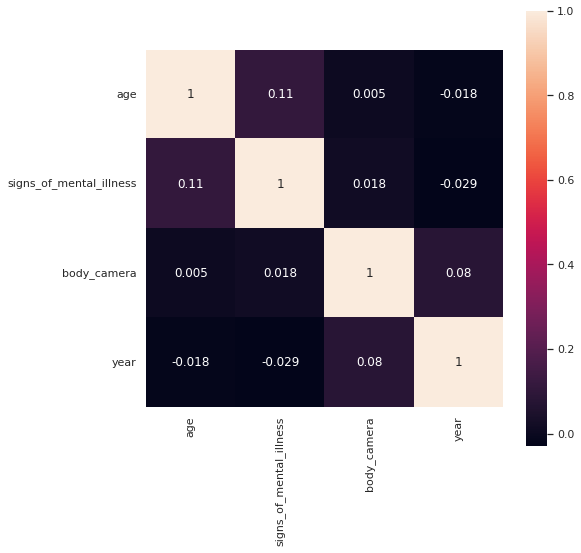

In [19]:
fig, ax = plt.subplots(figsize=(8,8))
mask = np.triu(shooting_correlation)
sb.heatmap(shooting_correlation, annot=True, square=True);

<i>Observation:</i> <br>
- Upon easy correlation analysis, the features in this dataset do not seem to have any correlation whether it's positively or negatively correlated. <br>

<i>Suggestion:</i> <br>
- Further analysis needs to be done, to see the relation between these  features

### 3.2 Distribution of Ages

In [20]:
data['age'].describe().round()

count    1986.0
mean       36.0
std        13.0
min         6.0
25%        26.0
50%        34.0
75%        45.0
max        83.0
Name: age, dtype: float64

<i>Observation</i>:<br>
- 95% of killings are aged 11-63

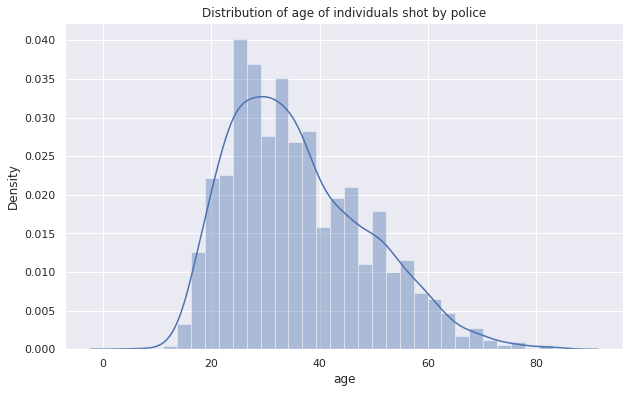

In [21]:
fig = plt.figure(figsize=(10,6))
sb.distplot(data['age'],bins=30)
plt.title('Distribution of age of individuals shot by police')
plt.show()

In [22]:
data.query('age <20').shape

(118, 16)

<i>Observation</i>:<br>
- Most of the individuals shot and killed by police were between the ages of 20 and 40, with very few older than 80 or younger than 16. 
Though there are 118 children under the age of 20 that were killed by police.


#### 3.2.1 Analysis of Race Vs Age

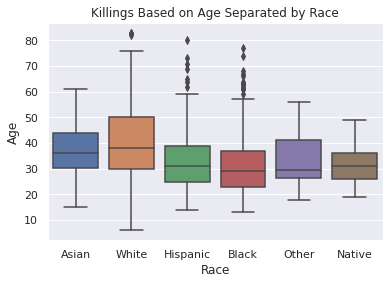

In [23]:
race_and_age = data.groupby('race')
sb.boxplot(x='race', y='age', data=data)

plt.xlabel("Race")
plt.ylabel("Age")
plt.title("Killings Based on Age Separated by Race")
plt.show()

<i>Observation:</i><br>
- From the above visualization we can see the mean age for each race. Mean age for most of the races are in there 30's and all of them being in the arly 30's, except of the white population that had there mean centered around late 30's.
- From the graph it looks like the race with the most range of killings is the White population who looks to have the min and max values of our dataset. 
- The Asian, Hispanic and Black population look very close together. The Native American population seems to have the least amount of range having the people killed by police being between late teens and late 40's.

#### 3.2.3 Comparision of youngsters(<30) and adults(>=30) killing between each race

In [24]:
def makeQuery(df:pd.DataFrame, feature:str, condition:str)->pd.DataFrame:
    '''Returns result of sorted DataFrame based on certain features'''

    query_string = feature + condition
    return df.query(query_string)

In [25]:
feature1 = 'race'
feature2 = 'age'
df1 = makeQuery(data, feature2, '>=30')[[feature1,feature2]]
df2 = makeQuery(data, feature2, '<30')[[feature1, feature2]]

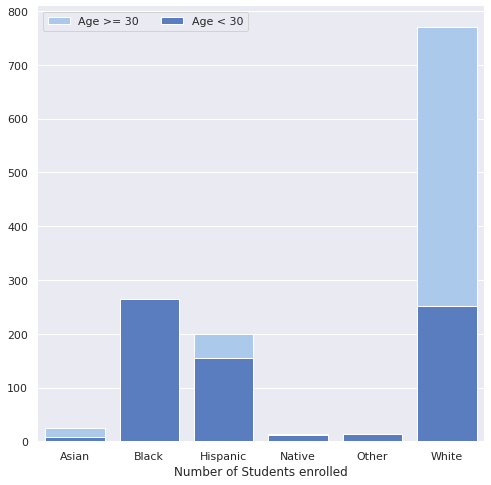

In [26]:
a = df1.groupby(feature1)[feature1].count()
b = df2.groupby(feature1)[feature1].count()

f, ax = plt.subplots(figsize=(8, 8))
sb.set_color_codes("pastel")
sb.barplot(y=a, x = a.index,label="Age >= 30", color="b")
sb.set_color_codes("muted")
sb.barplot(y=b, x=b.index, label="Age < 30", color="b")
ax.legend(ncol=2, loc="upper left", frameon=True)
ax.set(ylabel="", xlabel="Number of Students enrolled")
sb.despine(left=True, bottom=True)

<i>Observation</i>:<br>
- Most of the Victims from Black and Native Population are younger than 30's
- For Asian, Hispanic, and White population most of the victims are older than 30

### 3.3 Number of Shootings by weapon carried

In [27]:
#selecting top 10 used weapons
weapons = data['armed'].value_counts()
weapons = weapons[:10]

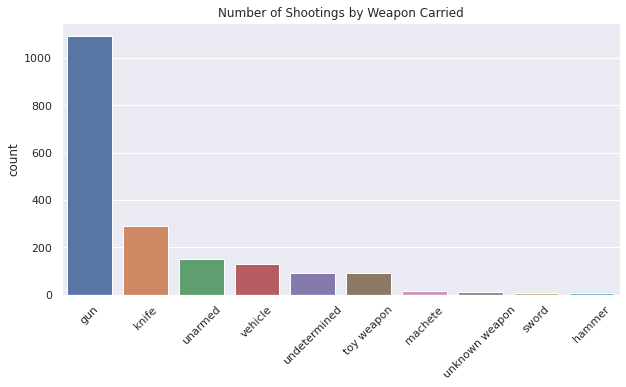

In [28]:
#making the plot
fig, ax = plt.subplots(figsize=(10, 5))
sb.barplot(weapons.index, weapons)
plt.ylabel('count')
plt.title('Number of Shootings by Weapon Carried')
plt.xticks(rotation=45);

<i>Observations</i>:<br>
- Most of victims had a Gun or a Knife at time of incident. 
- An alarmingly high proportion of individuals shot by police were either Unarmed or Armed with a Toy Weapon


### 3.4 Race and Death (Overview of Deaths by Race)
This section focuses on the rate at which each race is being killed by police. Comparing rate of death of each race is more important than just counting how many people have been killed from each race. This way we are able to weigh our information by comparing deaths by population.

#### 3.4.1 Visualizing percentage's of peoples killed from different race in span of 2 years

In [29]:
def makePlot(plot_type:str, data:pd.DataFrame, \
                    feature:str, title:str = '', label:str = '', label2:str = '')->None:
    ax = None
    plt.figure(figsize=(6,5))
    if plot_type == 'boxplot':
        plt.boxplot(data =data , x = feature);
    else:
        ax = sb.countplot(data = data, x = feature)
    plt.xlabel(label2)
    plt.ylabel(label)
    plt.title(title)
    
    if ax is not None:
        for p in ax.patches:
            percentage = '{:.1f}%'.format(100 * p.get_height()/len(data))
            x = p.get_x() + p.get_width() - 0.5
            y = p.get_height() + 0.1
            ax.annotate(percentage, (x, y))
    plt.show()

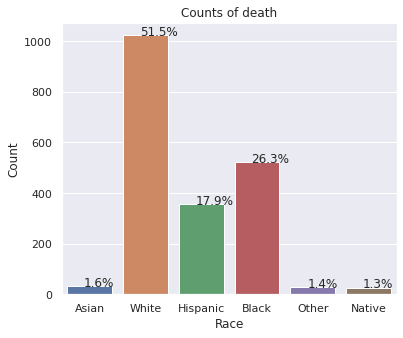

In [30]:
ylabel = 'Count'
xlabel = 'Race'
title = 'Counts of death'
makePlot('seaborn', data, 'race',title, ylabel, xlabel)

<i>Observation</i>:<br>
- Whites, Blacks, and Hispanics are the three highest race deathrates in this dataset. The population in the US is more than 317 million people (the population density - 29 people per 1 km2). According to the ethnic composition of the US population is represented by: white (63%); Hispanics (16.7%); African Americans (12.3%); Asians (4.8%); other nationalities (3.2%). The above simple analysis could suggest discrimination, so we should use proportion to get unbiased result.
- In order to get unbiased result, I'll take information from Statista that will give me the population of each race in the United States for the year 2016. The link will be inserted below: https://www.statista.com/statistics/183489/population-of-the-us-by-ethnicity-since-2000/

Since the racial composition of the United States is not equal, we will  need to work with proportions. <br> The following numbers are taken from the above website

    White : 248,410,000
    Black : 42,970,000
    Hispanic : 60,570,000
    Asian : 18,280,000
    Native American : 4,050,000

In [31]:
demographics = [248410000, 42970000, 60570000, 18280000, 846000, 4050000]
population = pd.Series(demographics, index = ['White', 'Black', 'Hispanic', 'Asian', 'Other', 'Native'])
race_death = data.race.value_counts()

In [32]:
proportion = pd.DataFrame(data = { race: [race_death[race]/population[race]] for race in population.index})
proportion

,White,Black,Hispanic,Asian,Other,Native
0,0.000004,0.000012,0.000006,0.000002,0.000033,0.000006


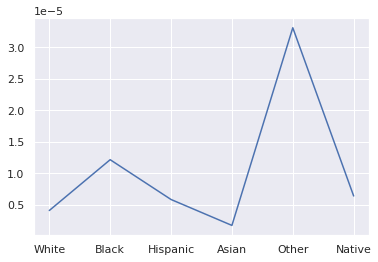

In [33]:
s = pd.Series({ race: race_death[race]/population[race] for race in population.index}, name = 'race_killing_rate')
s.plot()
plt.show()

<i>Observation</i><br>
- The rate at which the Black population is being killed is 3 times higher than the White population, and 2 times higher than Native and Hispanic population. Asia population has the lowest rate of killings.

### 3.5 Unarmed Killings By Race

In [34]:
# Grouping the data by race and if they were armed or not
df_armed = data
df_armed["armed"] = data["armed"] != "unarmed"

race_armed = df_armed.groupby(["race", "armed"], as_index=False).index.count()
race_armed.sort_values(by=["armed", "index"], ascending=[False, False], inplace=True)
race_armed = race_armed.rename(columns={"index": "count"})
race_armed

,race,armed,count
10,White,True,962
2,Black,True,467
4,Hispanic,True,326
0,Asian,True,32
6,Native,True,24
8,Other,True,24
9,White,False,60
1,Black,False,56
3,Hispanic,False,29
7,Other,False,4


In [35]:
# Calculating the proportion of armed and unarmed police shootings
armed_race_proportion = (
    race_armed.pivot("race", "armed", "count")
    .apply(lambda x: x / x.sum(), axis=1)
    .sort_values(by=True)
    .dropna()
)
armed_race_proportion

armed,False,True
race,,
Other,0.142857,0.857143
Black,0.107075,0.892925
Hispanic,0.081690,0.918310
Native,0.076923,0.923077
White,0.058708,0.941292


<i>Observation:</i> <br>
- The biggest proportion of armed victims are white, but let us plot the results, to have a better understanding of the scale

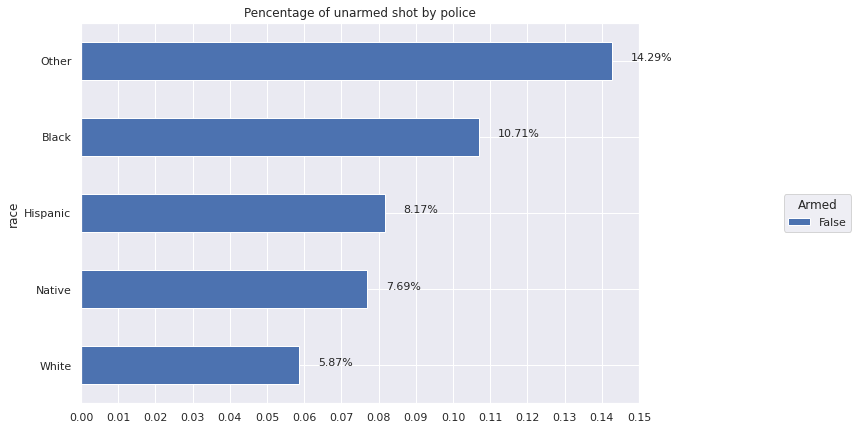

In [36]:
# Plotting the results
fig, ax = plt.subplots(figsize=(10, 7))
armed_race_proportion[False].plot(kind="barh", stacked=True, ax=ax) \
.legend(loc="center left", bbox_to_anchor=(1.25, 0.5), ncol=1, title="Armed")

plt.xticks(np.arange(0, np.max(armed_race_proportion[False]) + 0.01, 0.01))

for i in ax.patches:
    ax.text(
        i.get_width() + 0.005,
        i.get_y() + 0.25,
        str(round((i.get_width() * 100), 2)) + "%",
        fontsize=11,
    )
    
ax.invert_yaxis()
plt.title("Pencentage of unarmed shot by police")
plt.show()

<i>Observation:</i> <br>
- The graph shows that only about 6% of white people were shot unarmed, while the rate for black people is almost double at about 11%. 

### 3.6 Gender and Death

#### 3.6.1 Percentage of Men and Women killed fatally by police 

In [37]:
male_victim = data[data['gender']=='M'].shape[0]
female_victim = data[data['gender']=='F'].shape[0]
print(f'Number of Male Victim :  {male_victim}')
print(f'Number of Female Victim: {female_victim}')

Number of Male Victim :  1902
Number of Female Victim: 84


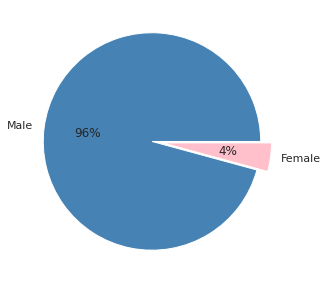

In [38]:
#relationship between death and gender
explode = (0.1, 0)
fig = plt.figure(figsize = (10,5))
palette_color = ['steelblue', 'pink'] 
plt.pie([male_victim, female_victim], explode = explode, labels=["Male", "Female"], colors = palette_color, autopct='%.0f%%')
plt.show()

<i>Observation:</i> <br>
- The analysis shows that out of 1902 peoples that were killed fatally by police between in span of 2 year 95.8% of them were males compared to 4.2% of females.


#### 3.6.2 Gender and Threat Level

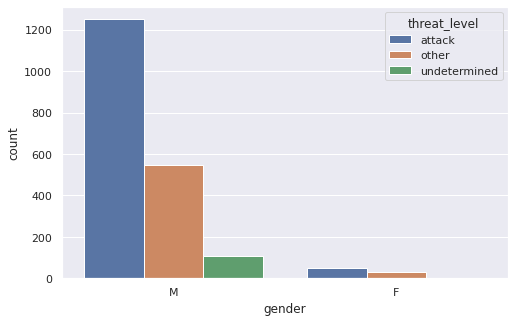

In [39]:
fig = plt.figure(figsize=(8,5))
sb.countplot(x='gender', data=data, hue='threat_level')
plt.show()

### 3.7 Fleeing and Killings 

#### 3.7.1 Percentage of methods used to victims to flee out of the scene

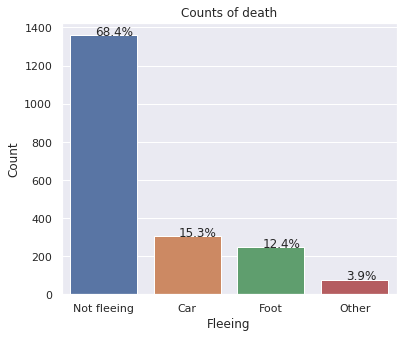

In [40]:
# relationship between types of fleeing and death
ylabel = 'Count'
xlabel = 'Fleeing'
title = 'Counts of death'
makePlot('seaborn', data, 'flee',title, ylabel, xlabel)

<i>Observation:<i><br>
- From above we can see that there are four different classifications in the 'flee' category. These are Not fleeing, Car, Foot, and Other.
- We can see that the Not fleeing classification occurred 1358 times which makes up for 68% of the dataset.
- Only 17% of people tried to flee by car and 13% tried to flee by foot

### 3.8 Threat Level and Police Shootings

#### 3.8.1 Percentage of Threat levels

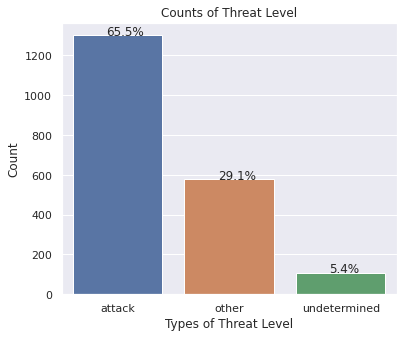

In [41]:
#relationship between certification and course counts
ylabel = 'Count'
xlabel = 'Types of Threat Level'
title = 'Counts of Threat Level'
makePlot('seaborn', data, 'threat_level',title, ylabel, xlabel)

<i>Observation:</i> <br> 
- Approximately 65% were labeled 'attack,' 29% 'other', 5% 'undetermined'

#### 3.8.2 Threat Level and Races

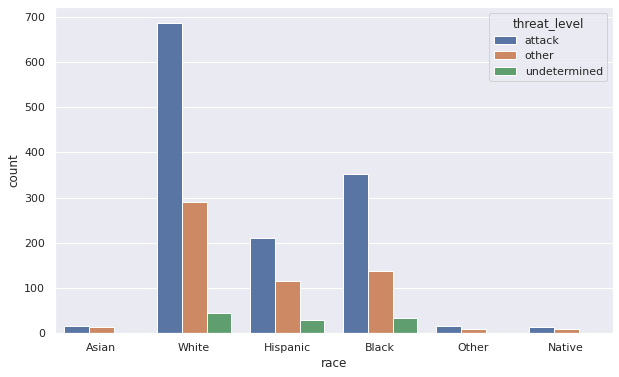

In [42]:
fig = plt.figure(figsize=(10,6))
sb.countplot(x='race', data=data, hue='threat_level')
plt.show()

#### 3.8.3 Threat Levels and Body Camera

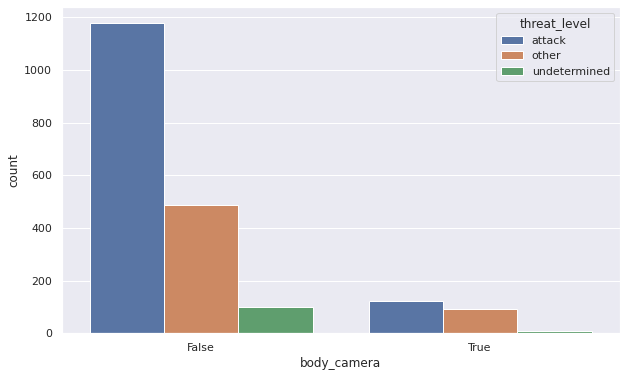

In [43]:
fig = plt.figure(figsize=(10,6))
sb.countplot(x='body_camera', data=data, hue='threat_level')
plt.show()

In [44]:
#number of attacks when camera is present
attack_camera_present = data[(data['body_camera']==True) & (data['threat_level']=='attack')].shape[0]
total_camera_present = data[(data['body_camera']==True)].shape[0]

attack_no_camera = data[(data['body_camera']==False) & (data['threat_level']=='attack')].shape[0]
total_camera_absent = data[(data['body_camera']==False)].shape[0]

print('Total Number of times when there was a camera:', total_camera_present)
print('Number of attacks when there is a camera:', attack_camera_present)
print('Percentage of attack when there is a camera:', round(attack_camera_present/total_camera_present, 4) * 100)
print('Total number of times when there was no camera:', total_camera_absent)
print('Number of attacks when there is no camera:', attack_no_camera)
print('Percentage of attack when there is no camera:', round(attack_no_camera/total_camera_absent, 4) * 100)
print('Attacks, Camera present vs not present:', round(attack_camera_present/(attack_camera_present+attack_no_camera),2)*100)

Total Number of times when there was a camera: 221
Number of attacks when there is a camera: 121
Percentage of attack when there is a camera: 54.75
Total number of times when there was no camera: 1765
Number of attacks when there is no camera: 1179
Percentage of attack when there is no camera: 66.8
Attacks, Camera present vs not present: 9.0


<i>Observation:</i> <br>
- There seems to be a problem with body camera footage when there is an 'attack' level threat, or really when there is a killing in general.
- However, the proportion of 'attack' threat levels that were not recorded make up 65% of deaths, while the proportion of recorded deaths that were labeled 'attack' threat level was closer to 60%. This could be a policy issue.

### 3.9 Comparision of shootings between states and cities

In [45]:
#total number of states where fatal shootings happened
data['state'].unique().size

51

<i>Observation:</i> <br> 
- Fatal shootings by police has happened in all 50 states of US and Washington DC. 

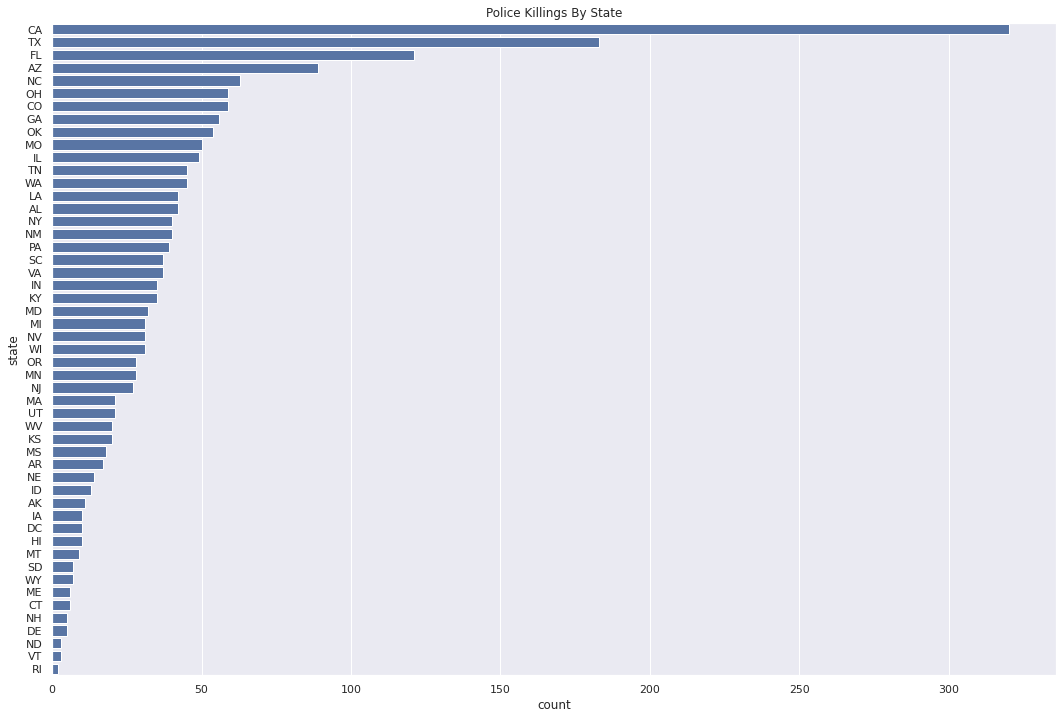

In [65]:
plt.figure(figsize=(18, 12))
sb.countplot(y="state", data=data,order=data.state.value_counts().index, color = base_color)
plt.title('Police Killings By State')
plt.show()

<i>Observation:</i> <br>
- California is the state with the Highest Number of Killings followed by Texas, Florida, Arizona, and so on
We can see that California has by far the most fatal shootings by the police

### States Population Size

In [69]:
# https://www.census.gov/data/datasets/2017/demo/popest/state-total.html
state_population ={
        'AL': 4874747,
        'AK': 739795,
        'AZ': 7016270,
        'AR': 3004279,
        'CA': 39536653,
        'CO': 5607154,
        'CT': 3588184,
        'DE': 961939,
        'DC': 693972,
        'FL': 20984400,
        'GA': 10429379,
        'HI': 1427538,
        'ID': 1716943,
        'IL': 12802023,
        'IN': 6666818,
        'IA': 3145711,
        'KS': 2913123,
        'KY': 4454189,
        'LA': 4684333,
        'ME': 1335907,
        'MD': 6052177,
        'MA': 6859819,
        'MI': 9962311,
        'MN': 5576606,
        'MS': 2984100,
        'MO': 6113532,
        'MT': 1050493,
        'NE': 1920076,
        'NV': 2998039,
        'NH': 1342795,
        'NJ': 9005644,
        'NM': 2088070,
        'NY': 19849399,
        'NC': 10273419,
        'ND': 755393,
        'OH': 11658609,
        'OK': 3930864,
        'OR': 4142776,
        'PA': 12805537,
        'RI': 1059639,
        'SC': 5024369,
        'SD': 869666,
        'TN': 6715984,
        'TX': 28304596,
        'UT': 3101833,
        'VT': 623657,
        'VA': 8470020,
        'WA': 7405743,
        'WV': 1815857,
        'WI': 5795483,
        'WY': 579315
      }

### Actual Police Killing vs Population Distribution by State

In [132]:
state_population_s = pd.Series(state_population)
death_by_state = data.state.value_counts()
proportion_by_state  = pd.DataFrame(data = { state: [death_by_state[state]/state_population_s[state]] for state in state_population_s.index})
proportion_by_state = proportion_by_state.transpose()
proportion_by_state.reset_index(inplace=True)
proportion_by_state.columns = ['state', 'rate_death']
proportion_by_state

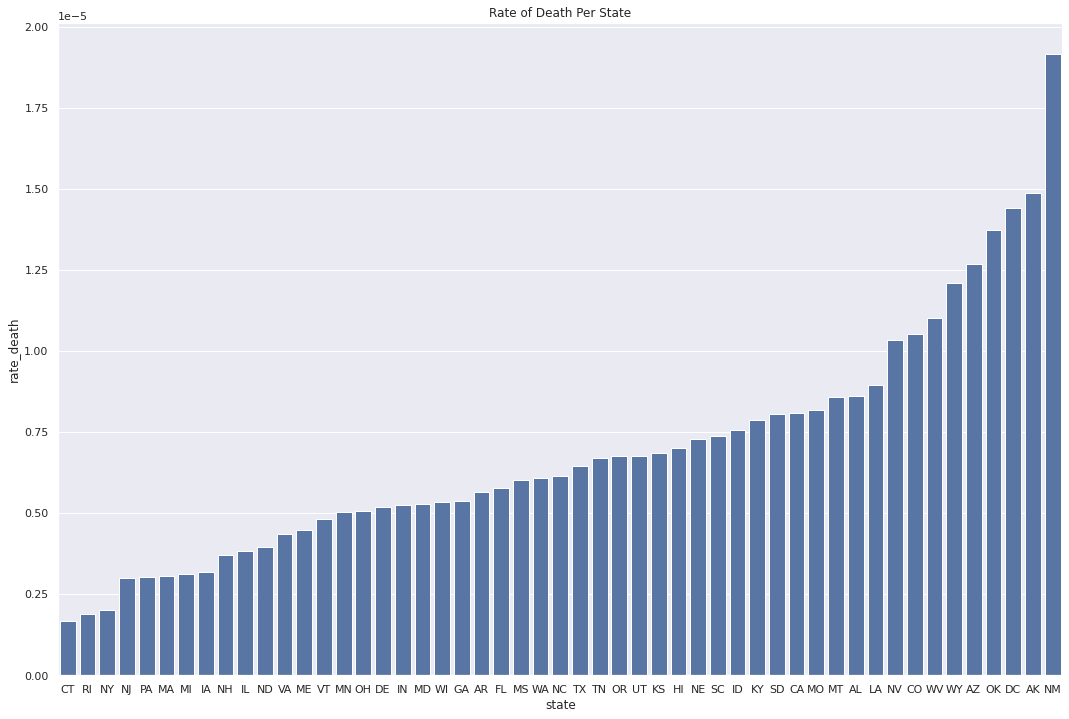

In [130]:
plt.figure(figsize=(18, 12))
sb.barplot(
           data=proportion_by_state, x="state", y="rate_death", 
           order = proportion_by_state.sort_values('rate_death').state, color = base_color
           )
plt.title('Rate of Death Per State')
plt.show()

<i>Observation</i><br>
- The rate of death per population size is highest at state of New Mexico, followeb by Arkansas and Washington DC.
- The rate of death per population size is loweest at state of Connecticut.

#### 3.9.1 Fatal Killings and cities

In [47]:
#total number of cities where fatal shootings happened
data['city'].unique().size

1159

<i>Observation:</i> <br>
- There are 1159 unique cities in this dataset where fatal shootings happened.

In [48]:
kills_by_city = data.groupby(['city'])['name'].count()
kills_by_city = kills_by_city.sort_values(ascending=False)[:50]

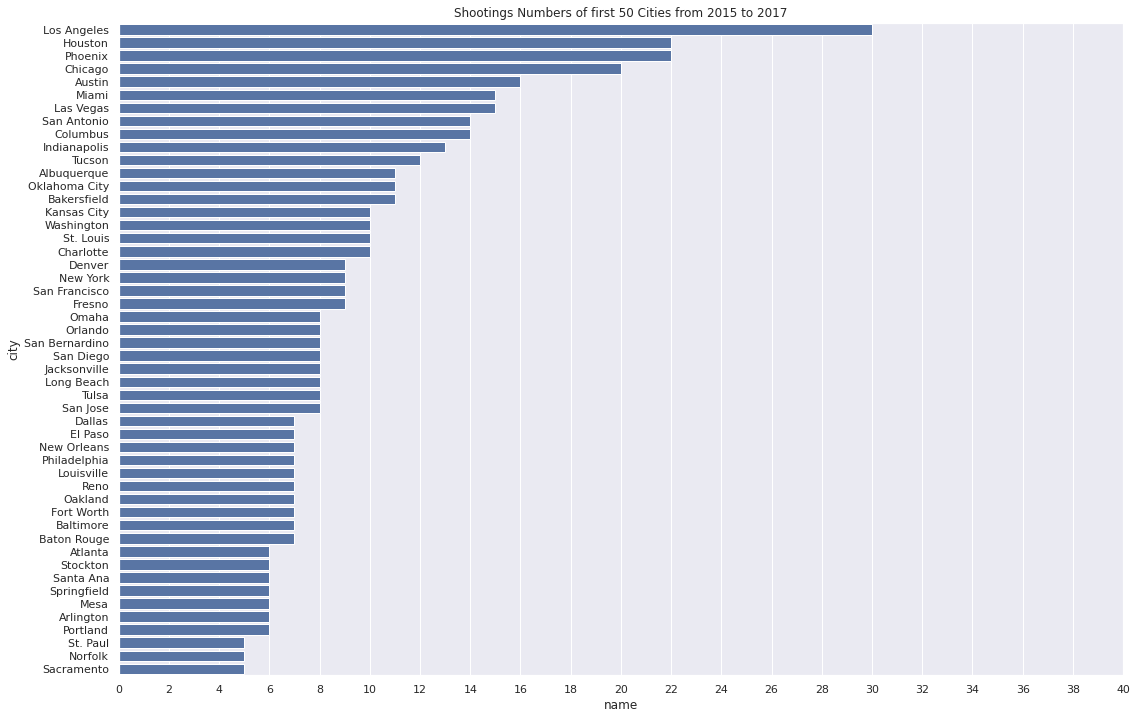

In [66]:
fig, ax = plt.subplots(figsize=(18, 12))
sb.barplot(x=kills_by_city, y=kills_by_city.index, color = base_color)
plt.xticks(np.arange(0, 41, 2))
plt.title('Shootings Numbers of first 50 Cities from 2015 to 2017');

<i>Observation:</i> <br> 
- The city of Los Angeles is the first where fatal shootings frequently happen, whereas  Springfield is one of the less frequent

### 3.10 Shooting Frequency Over Times

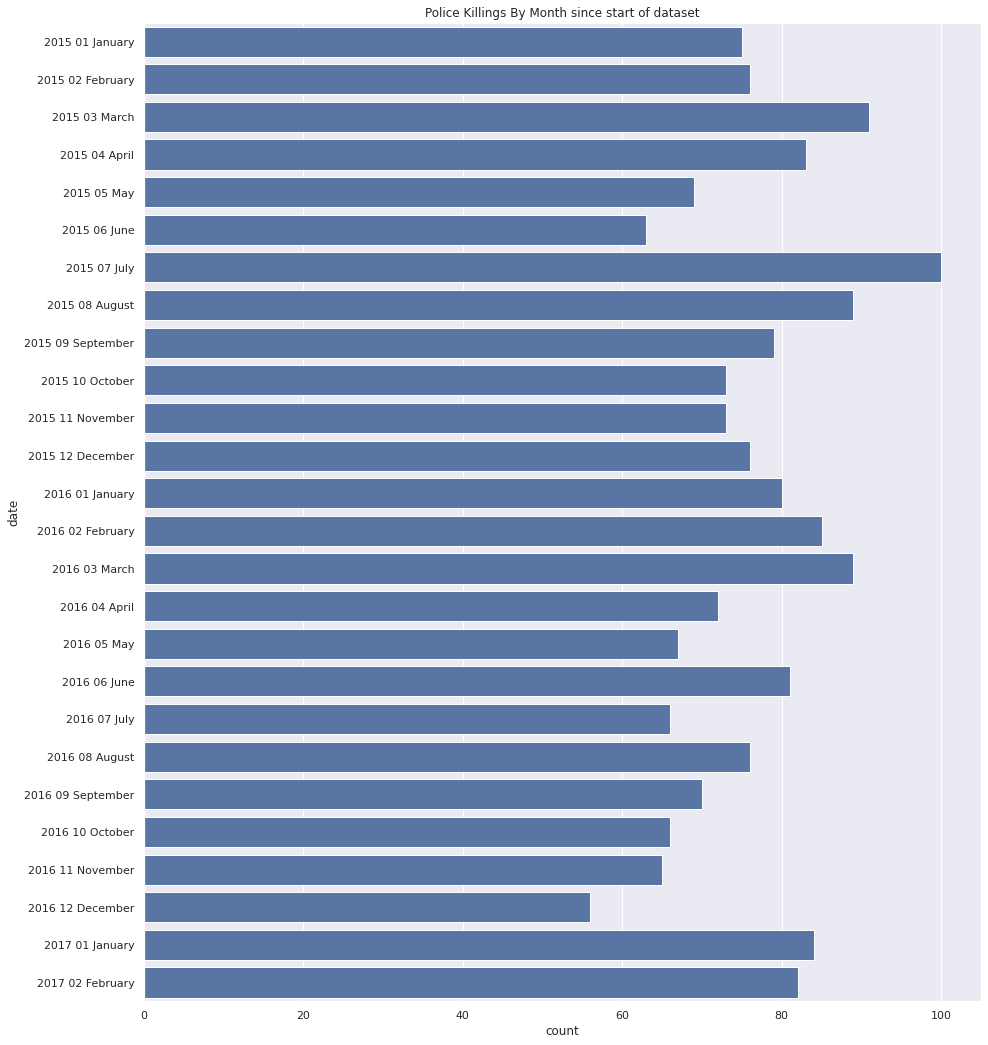

In [63]:
# Convert date from object to datetime
data.date = pd.to_datetime(data.date)
plt.figure(figsize=(15,18))
sb.countplot(y=data.date.dt.strftime('%Y %m %B'), order=sorted(data.date.dt.strftime('%Y %m %B').unique()), color = base_color)
plt.title('Police Killings By Month since start of dataset')
plt.show()

#### 3.10.2 Fatal Killings and Year

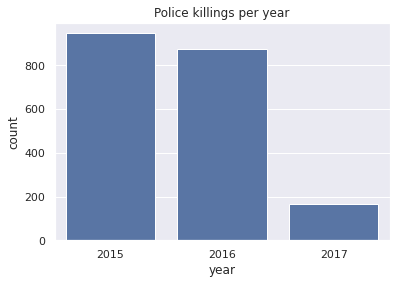

In [51]:
base_color = sb.color_palette()[0]
sb.countplot(data = data, x = 'year', color = base_color)
plt.title('Police killings per year');

<i>Observation:</i> <br>
- we can see that almost fatal shootings for year 2015 and 2016 are the same. 
- The reason why 2017 plot is low compared to other year's is because, the dataset is not complete and we are only accounting for 2 months of 2017. 

### 3.11 Mental Illness and Police Shooting
Since we have the data, I would like to begin by exploring the data on mental ilness and shootings. I want to know where the mentally ill are shot most frequently

In [52]:
# Grouping the data by state and if there are signs of mental ilness
mental_ilness = data.groupby(["state", "signs_of_mental_illness"], as_index=False).index.count()
mental_ilness.sort_values(by=["signs_of_mental_illness", "index"], ascending=[False, False], inplace=True)
mental_ilness = mental_ilness.rename(columns={"index": "count"})
mental_ilness

,state,signs_of_mental_illness,count
9,CA,True,76
84,TX,True,45
19,FL,True,34
7,AZ,True,25
92,WA,True,19
...,...,...,...
16,DE,False,4
79,SD,False,4
56,ND,False,3
76,RI,False,2


In [53]:
# Filter cases where signs of mental ilness were present
mental_ill_victim = (
    mental_ilness[mental_ilness["signs_of_mental_illness"] == True]
    .drop("signs_of_mental_illness", axis=1)
    .reset_index(drop=True)
)
mental_ill_victim

,state,count
0,CA,76
1,TX,45
2,FL,34
3,AZ,25
4,WA,19
5,NC,16
6,NY,16
7,OK,14
8,VA,14
9,GA,12


#### 3.11.1 Visualization of shootings where mental ilness present per states

In [54]:
# Interactive map of the USA to visualise shootings where signs of mental illness were present
fig = px.choropleth(
    mental_ill_victim,
    locations="state",
    color="count",
    hover_name="state",
    locationmode="USA-states",
)
fig.update_layout(
    title_text="Fatal shootings of people with signs of mental illness in each state",
    geo_scope="usa",
)
fig.show()

#### 3.11.2 Comparision of fatal shootings where mental ilness present and not present  per states

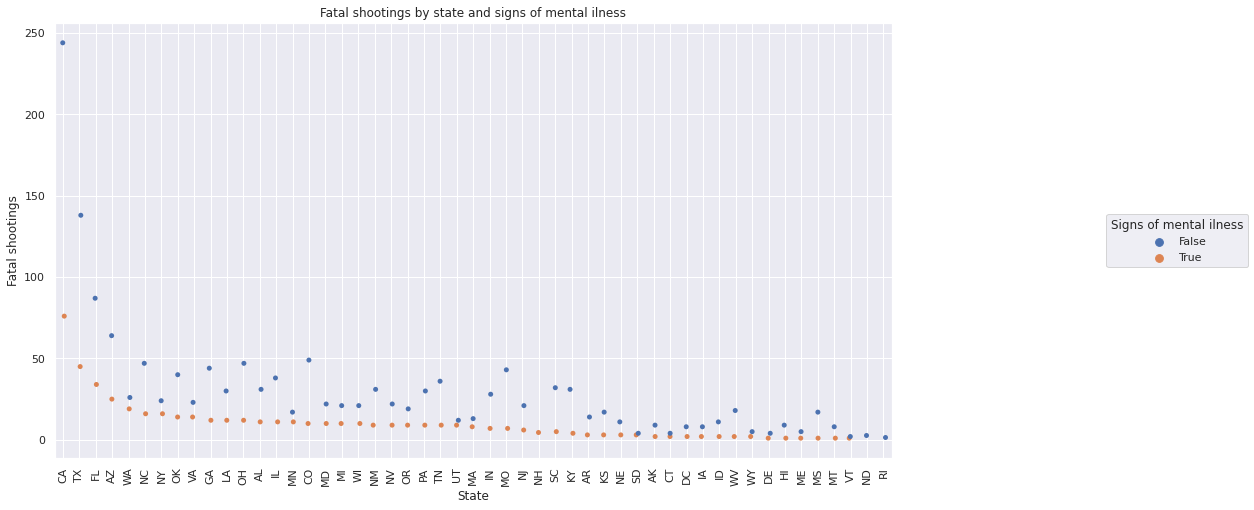

In [55]:
# Plotting the data
fig, ax = plt.subplots(figsize=(15, 8))
sb.stripplot(
    ax=ax, data=mental_ilness, x="state", y="count", hue="signs_of_mental_illness"
).legend(
    loc="center left",
    bbox_to_anchor=(1.25, 0.5),
    ncol=1,
    title="Signs of mental ilness",
)
plt.xticks(rotation=90)
ax.xaxis.grid(True)
plt.ylabel("Fatal shootings")
plt.xlabel("State")
plt.title("Fatal shootings by state and signs of mental ilness")
plt.show()

### 3.12 Statistical Probability Prediction

Upto this point we were using the actual killings against population distribution. Instead we can compute a value that tells us the probability of number of killings from each race if the killings were random, given the population distribution. We'll use Poission distribution to model the probability of observing the number of killings given the population size in a given race.

A Poisson distribution is a tool that helps to predict the probability of certain events happening when you know how often the event has occurred. In this particular we are also interested in the direction in which the probability is going to be. This means we are going to find out if the number of killings were less or more for certain race if the killings were random. Therefore, we'll use the cumulative  of the Poisson distribution. This  tell us the probability of observing a given number of killings or less.

<i>Cumulative Probability of Poission Distribution Value Ranges Analysis:</i> <br>
- if it's closer to 0, that means there were less killings of a certain population than would be expected if killings were random.
- If the value is closer to 1, there were more killings than would be expected if killings were random.
- If the value is around 0.5, police shootings of people in that population were relatively unbiased.

<i>Cumulative Probabililty of Poission Distribution Formula <i>:<br>
$$ p(X<=k) = e^{-λ}\sum_{i=0}^{|k|}\frac{λ^i}{i!}$$ <br>
$$ λ = Np * \frac{Nk}{Ntotal} $$
<i>Where</i>:<br>
- λ: is the expected number of death if killings were random, given the population distribution
- k: number of recorded killings
- Np: total number of individuals in a population
- Nk: Number of people shot and killed by police
- Ntotal: total number of people in USA


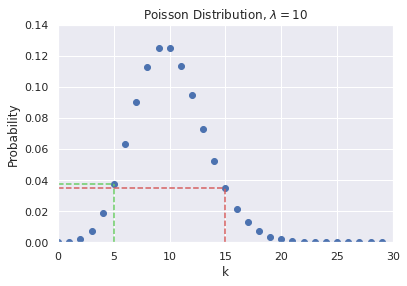

In [56]:
expected_lambda = 10 #lasmbda, the "expected" number
k1 = 5   #k, the actual number, when more than expected
k2 = 15  #k, the actual number, when less than expected
x_range = np.arange(0,30)
ppd = poisson.pmf(x_range, expected_lambda) #poisson probability distribution
p_k1 = poisson.pmf(k1, expected_lambda) #probability of observing k1
p_k2 = poisson.pmf(k2, expected_lambda) #and k2

plt.figure()
plt.plot(x_range,ppd, 'o')
plt.plot([k1, k1], [0, p_k1], 'g--')
plt.plot([0, k1], [p_k1, p_k1], 'g--')
plt.plot([k2, k2], [0, p_k2], 'r--')
plt.plot([0, k2], [p_k2, p_k2], 'r--')
plt.title(r'Poisson Distribution, $\lambda=10$')
plt.xlabel('k')
plt.ylabel('Probability')
plt.xlim([0, 30])
plt.ylim([0, 0.14])
plt.show()

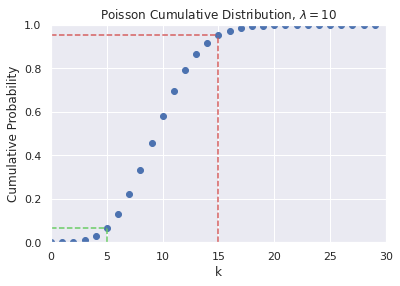

In [57]:
cppd = poisson.cdf(x_range, expected_lambda) #cumulative poisson distribution
c_k1 = poisson.cdf(k1, expected_lambda) #cumulative probability of observing k1
c_k2 = poisson.cdf(k2, expected_lambda) #and k2

plt.figure()
plt.plot(x_range,cppd, 'o')
c_k1 = poisson.cdf(k1, expected_lambda)
plt.plot([k1, k1], [0, c_k1], 'g--')
plt.plot([0, k1], [c_k1, c_k1], 'g--')
plt.plot([k2, k2], [0, c_k2], 'r--')
plt.plot([0, k2], [c_k2, c_k2], 'r--')
plt.title(r'Poisson Cumulative Distribution, $\lambda=10$')
plt.xlabel('k')
plt.ylabel('Cumulative Probability')
plt.xlim([0, 30])
plt.ylim([0, 1])
plt.show()

<i>Observation</i>:<br>
- We can see that when there are less killings in a population than would be expected if killings were random, the cumulative probability value approaches 0, while when there are more than expected, the cumulative probability value approaches 1.

Now we'll see which race have less police killings than the national average and which race have more police killings than the national average.

In [58]:
# population percentage
# source https://www.census.gov/quickfacts/fact/table/US
population_ratio = {
            'White': 60.7, 
            'Black': 13.4, 
            'Hispanic': 18.1, 
            'Asian': 5.8,  
            'Native': 1.5,  
            'Other': 0.5
         }

In [168]:
def getProbabilityDistribution(feature:str, data:pd.DataFrame, population:Dict)->pd.DataFrame:
    num_obs = data.shape[0]
    rate = num_obs if feature == 'race' else num_obs/sum(population.values())
    cum_poisson_vals = []

    for key in population.keys():
        lam = rate * population[key]/100 if feature == 'race' else rate * population[key]
        k = data[data[feature]==key].shape[0] #actual number of shootings of people of this race
        cum_poisson_vals.append(poisson.cdf(k, lam))
    
    Expected_DF = pd.DataFrame(data={feature: list(population.keys()), 
                        'cum_poisson': cum_poisson_vals})
    Expected_DF.sort_values('cum_poisson', inplace=True)
    return Expected_DF

In [169]:
def probabilityPlot(data:pd.DataFrame):
  
    feat1, feat2 = data.columns
    y = np.arange(len(data[feat1]))
    plt.barh(y, data[feat2]-0.5, left=0.5)
    plt.plot([0.5, 0.5], [y[0]-1, y[-1]+1], 'k', linewidth=2)
    ax = plt.gca()
    ax.set_yticks(y)
    ax.set_yticklabels(data[feat1])
    ax.invert_yaxis()
    plt.title(f'Police Shootings: Cumulative Probability\ngiven national average, by {feat1}')
    plt.ylabel('Cumulative Poisson Probability')
    plt.xlabel(xlabel)

    textY  = y[0]-0.75 if feat1 == 'race' else y[0]-1.5
    textX  = 0.506 if feat1 == 'race' else 0.505

    plt.text(textX, textY,
         r'Less shootings $\leftarrow$ $\rightarrow$ More shootings',
         horizontalalignment='center', color='gray')
    plt.show()

In [170]:
Expected_killing_by_race = getProbabilityDistribution('race', data, population_ratio)
Expected_killing_by_race

,race,cum_poisson
3,Asian,4.557776e-20
0,White,3.179740e-08
4,Native,2.798946e-01
2,Hispanic,4.204438e-01
5,Other,9.999993e-01
1,Black,1.000000e+00


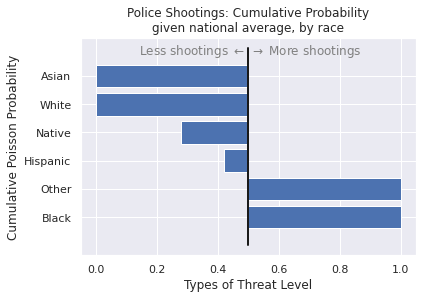

In [153]:
probabilityPlot(Expected_killing_by_race)

<i>Observation</i>:<br>
- This results suggest that police shootings are racially based.
- The probability of observing so many shootings of white and asian individuals are almost zero
- The probability of observing so few shootings of Black and other individuals are almost zero

In [172]:
Expected_killing_by_state = getProbabilityDistribution('state', data, state_population)
Expected_killing_by_state

,state,cum_poisson
32,NY,1.032549e-17
38,PA,7.595608e-07
22,MI,1.948897e-05
30,NJ,2.329422e-05
6,CT,6.479443e-05
13,IL,2.832775e-04
21,MA,2.899855e-04
15,IA,1.668641e-02
46,VA,2.039416e-02
39,RI,4.429431e-02


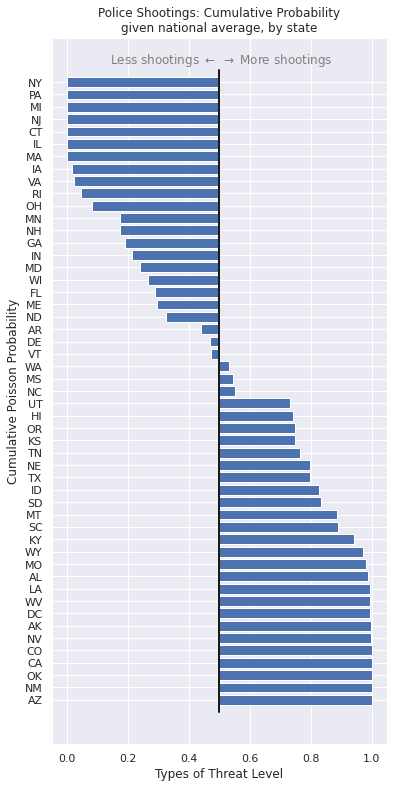

In [174]:
# Plot cumulative Poisson distribution values
plt.figure(figsize=(6, 13))
probabilityPlot(Expected_killing_by_state)

<i>Observation:<i><br>
- State of Arizona has the highest frequency of police shootings if the shootings were random given its population 
- State of New York has the least frequecy of police shootings if the shootings were random given its population size.

## 3.13 KMeans Clustering Data / Unsupervised Machine Learning

first step of clustering

## 4.Conclusion



Findings:
- Most of the victims are killed by shooting;
- White and Black race people are the most affected;
- Black Race people are widely killed in the US comparing the relative proportion of the race in the United States;
- Males are more victims of fatal shootings than women;
- Victims with no sign of mental illness are three times than victims with a sign of mental illness;
- The undetermined threat level count seems negligible;
- The most person killed did not flee;
- The absence of a body camera is more frequent with respect to its presence.
- Most of the victims were youngsters (aged between 20 -40)
- The states of California, Texas, and Florida have recorded the most number of deaths
- In a significant amount of cases, the victim was either Unarmed or had a toy 
gun

In conclusion, the data analysis suggests that most of the victims were killed in a suspicious matter. For instance, the camera footage was missing for more than half of the killings registered in this dataset. The rate was also almost twice as high for the black population.

Note: These finding is not complete and needs further research and analysis to deduce racial-based killings. (The most important feature of this dataset)